# Basic Evalscripts

This notebook will give you an interactive overview of how to use evalscripts. It should give you all the tools to make your own evalscripts.

## Table of Contents
1. [Prerequisites](#prerequisites)
2. [Introduction to Evalscripts](#introduction-to-evalscripts)
3. [Structure of an Evalscript](#structure-of-an-evalscript)
4. [Sample Types and Visualization](#sample-types-and-visualization)
5. [Exercises](#exercises)
6. [Common Issues](#common-evalscript-issues)
7. [Computing Indices (NDVI, NDWI)](#computation-in-evalscripts)
8. [Dealing with Clouds and Missing Data](#dealing-with-clouds-and-missing-data)
9. [Summary and Further Reading](#summary)

## Prerequisites

To go through this notebook you will need some prior knowledge.

- [Basic Knowledge of Remote Sensing](https://business.esa.int/newcomers-earth-observation-guide)
  - Sensors
  - Spectral Bands
  - Indices
- [Basic Familiarity with Sentinel Hub](https://www.sentinel-hub.com/explore/education/webinars/)
  - Collections
  - Processing API
  - Statistical API
- Basic knowledge of programming concepts
  - [functions](https://www.w3schools.com/js/js_functions.asp)
  - [variables](https://www.w3schools.com/js/js_variables.asp)
  - [arrays](https://www.w3schools.com/js/js_arrays.asp)
  - [objects](https://www.w3schools.com/js/js_objects.asp)

If you are aware of the basics of all of these topics you are well equipped to tackle this notebook. First let's dive in to some basics about evalscripts.

## Introduction to Evalscripts

An **evalscript (also called a custom script)** is JavaScript that defines how satellite data should be processed by Sentinel Hub and what values the service should return. It is part of every Process/Batch/OGC request. 

If you think about a multispectral collection, it contains several spectral bands such as `blue`, `green`, `red` and `nir`. There are many ways this data can be displayed or returned: for example, you could return the raw values of a single band, generate a true-color image, or calculate an index like NDVI and return that. Together with the request body of a Processing API request, the evalscript is the key component that defines exactly what should be returned.

## When to use evalscripts

Evalscripts make computations on your data in the cloud possible. This makes data handling much more efficient since only the data you truly need will be returned to you. Evalscripts are often used to:

- Visualize a band or composite with specific colormaps
- Perform complex band calculations
- Combine multiple data sources into new insights
- Create cloud free composites
- Carry out multi-temporal analysis

## When not to use evalscripts

There's not many things that evalscripts can't do, since they support the full javascript language. However due to how evalscripts are structured it is only possible to do calculations on a per pixel basis. So if you need to return data which takes the neighboring pixels into account like calculating the Slope of a DEM, this unfortunately is not possible using an evalscript.

You also can't train machine learning models directly in an evalscript. However you can bring some Machine Learning models to an evalscript and predict values directly in the evalscript. [See here for an example](https://custom-scripts.sentinel-hub.com/custom-scripts/sentinel-2/bare_soil_detector/).

## Structure of an evalscript

The most basic structure of an evalscript is made up of two functions `setup()` and `evaluatePixel()`. Let's see how those two functions look like:

```js
function setup() {
   return {
       input: ["B04", "B03", "B02"],
       output: {bands: 3}
   };
}

function evaluatePixel(samples) {
   return [samples.B04, samples.B03, samples.B02]
}
```

The setup function takes care of supplying some of the necessary metadata on what kind of data will be requested and returned. Here we can see that it specifies which spectral bands should be requested. These are the bands you need in the `evaluatePixel` function to carry out your computation. In the setup function it is also specified how many bands will be returned by the `evaluatePixel` function. The setup function is implicitly called before any calcuations are taking place.

The `evaluatePixel` function will get values passed into it. The first parameter of the function holds the actual values of the data in the raw data store that you are requesting. In this case it is a [javascript object](https://www.w3schools.com/js/js_objects.asp) which has the requested bands as keys and the corresponding data as values. It is important to note that `samples` will only ever hold the values for a single Pixel. So the `evaluatePixel` function has to be specified in such a way that it works for every pixel which will be requested. In this example the samples object could look like this:

```
{"B04": 9864, "B03": 9536, "B02": 9472}
```

Here, we return red, green, and blue for a true-color visualization. Let's try this evalscript out and see what it returns:

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sentinelhub import (
    CRS,
    DataCollection,
    Geometry,
    MimeType,
    SentinelHubRequest,
    SHConfig,
)

config = SHConfig()
# config.sh_client_id = "<your_client_id>"
# config.sh_client_secret = "<your_client_secret>"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"

## Learning Objectives

By the end of this notebook, you will be able to:

✅ **Understand evalscript structure** - Know the key components of `setup()` and `evaluatePixel()` functions  
✅ **Work with sample types** - Choose appropriate sample types (AUTO, UINT8, UINT16, FLOAT32) for different use cases  
✅ **Handle band data** - Request and process spectral bands correctly  
✅ **Calculate indices** - Compute vegetation (NDVI) and water (NDWI) indices  
✅ **Visualize data** - Create both analytical outputs and visual representations  
✅ **Handle clouds and missing data** - Use SCL and dataMask for data quality control  
✅ **Debug evalscripts** - Identify and fix common evalscript errors  

Let's start by setting up our environment:

Since we will be doing quite a few requests where only the evalscript is different we will define a small helper function that takes in an evalscript as a parameter and returns the output of the request:

In [2]:
def request_helper(evalscript, date="2024-04-26"):
    """
    Helper function to make requests with evalscripts.

    Args:
        evalscript (str): JavaScript evalscript code
        date (str): Date for the request in YYYY-MM-DD format

    Returns:
        list: Response data from Sentinel Hub
    """
    if not evalscript.strip():
        raise ValueError(
            "Evalscript cannot be empty. Please provide a valid JavaScript evalscript."
        )

    aoi = Geometry(
        {
            "type": "Polygon",
            "coordinates": [
                [
                    [-52.307067, -27.262221],
                    [-52.307067, -27.238987],
                    [-52.280803, -27.238987],
                    [-52.280803, -27.262221],
                    [-52.307067, -27.262221],
                ]
            ],
        },
        CRS.WGS84,
    )
    request = SentinelHubRequest(
        evalscript=evalscript,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL2_L2A.define_from(
                    name="s2l2a", service_url="https://sh.dataspace.copernicus.eu"
                ),
                time_interval=(date, date),
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=aoi,
        size=[1000, 1000],
        config=config,
    )
    return request.get_data()

Now we can request data with our evalscript:

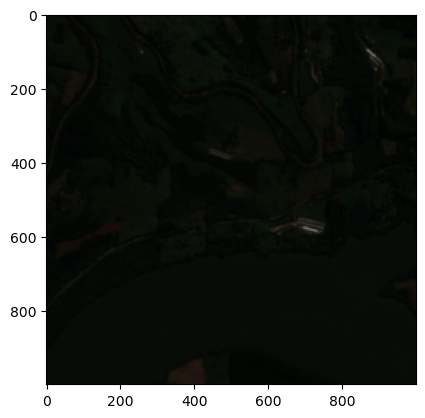

In [3]:
true_color_evalscript = """
//VERSION=3
function setup() {
    return {
        input: ["B04", "B03", "B02"],
        output: {bands: 3}
    };
}

function evaluatePixel(samples) {
    return [samples.B04, samples.B03, samples.B02]
}
"""
tc_output = request_helper(true_color_evalscript)
plt.imshow(tc_output[0]);

The image looks dark because Sentinel-2 stores reflectance values on a 0–10 000 scale, which is much lower than the 0–255 range used for display.

In [4]:
print("Min value: ", np.min(tc_output[0]), "\nMax value: ", np.max(tc_output[0]))

Min value:  1 
Max value:  124


This is a very common gotcha when using evalscripts. It has to do with the default values which are set in the `setup` function. So to clarify what just happened here let's have a look at the default value for `sampleType`:

## Sample Type

Aside from the number of returned bands, the setup function also specifies which sample type the returned values should have. The variable `sampleType` is defined under output:

```js
function setup() {
  return {
    input: ["B04", "B03", "B02"],
    output: {
      bands: 3,
      sampleType: "AUTO"
    }
  };
}
```

The requested sample type can be the standard types, like INT8, INT16 or FLOAT32. But the default value is `AUTO`. This custom sample type stretches reflectances (float numbers between 0-1) to UINT8 numbers (0-255) which are necessary to build images like PNGs and JPEGs. If you would like an introduction to sample types and more detail, have a look at [this](https://medium.com/sentinel-hub/sampletype-whats-all-the-fuss-about-d7348b4de647) blog post.

The `AUTO` sample type is useful when your data are already in reflectance values (0–1) and you just want to visualize them, for example via a WMS service. Sentinel-2 L2A, however, is delivered as digital numbers (DN). With `AUTO`, any value above 1 is capped at the display maximum (255), which can result in dark or flat images.

To fix this while using `AUTO` as sample type, we can scale the values to bring them into a better range for visualization:

```js
function evaluatePixel(samples) {
   let scale = 2.5;
   return [samples.B04*scale, samples.B03*scale, samples.B02*scale]
}
```

So let's try what this looks like:

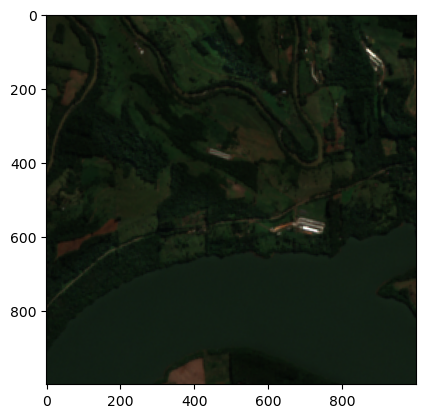

In [5]:
scaled_evalscript = """
//VERSION=3
function setup() {
   return {
       input: ["B04", "B03", "B02"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

function evaluatePixel(samples) {
   let scale = 2.5;
   return [samples.B04*scale, samples.B03*scale, samples.B02*scale]
}
"""
scaled_output = request_helper(scaled_evalscript)
plt.imshow(scaled_output[0]);

Much better! We can now actually see some details, however the whole image is still quite dark. To fix that we can apply a gain to brighten up the image. A `gain` is usually applied by multiplying the values by some factor. In our case, since the reflectance is already in the 0–1 range, multiplying by a `gain` greater than 1 increases brightness without manual scaling. Try different values for the `gain` variable in the next cell and observe how the image changes.

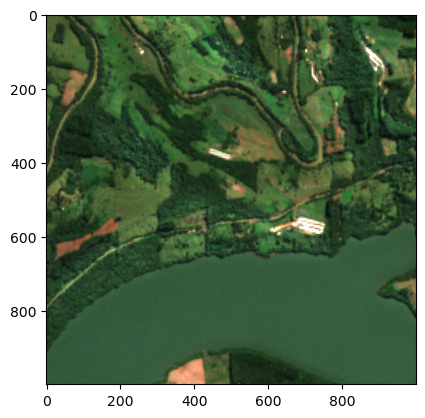

In [6]:
gain_evalscript = """
//VERSION=3
function setup() {
   return {
       input: ["B04", "B03", "B02"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

function evaluatePixel(samples) {
   let gain = 3;
   let scale = 2.5*gain;
   return [samples.B04*scale, samples.B03*scale, samples.B02*scale]
}
"""
gain_output = request_helper(gain_evalscript)
plt.imshow(gain_output[0]);

### Exercise: Returning raw values

Now you get to write an evalscript yourself. Rather than visualizing the data as RGB values in the 0–255 display range, let’s return the raw digital numbers (DN) for the three bands. Sentinel‑2 L2A stores reflectance as DN = 10,000 × reflectance, typically in a `UINT16` format. In your evalscript, make sure to specify appropriate units: "DN" and `sampleType`, such as `UINT16`, so you receive the raw values.

If you are stuck you can also have a look at the solution below.


#### Excursion: Common evalscript issues

Since in these exercises you might run into issues, here's a list of common issues to check:

<table>
   <thead>
      <tr>
         <th style="width:15%">To check</th>
         <th style="width:15%">Symptoms</th>
         <th>Problem</th>
         <th>Fix</th>
      </tr>
   </thead>
<tbody>
<tr>
<td>Do you return an array in the `evaluatePixel` function?</td>
<td>

- Failure to evaluate the script
- Can in some cases be a cryptic error

</td>
<td>

```js
function evaluatePixel(samples) {
  return samples.B04
}
```

</td>
<td>

```js
function evaluatePixel(samples) {
  return [samples.B04]
}
```

</td>
</tr>
<tr>
<td>Are all bands which you use in <code>evaluatePixel</code> also requested in the input of the setup function?</td>
<td>

- All black output
- Colors are completely off
- Result of calculated index is all NaN

</td>
<td>

```js
function setup() {
   return {
       input: ["B04", "B03"], // Issue!
       output: {bands: 3}
   };
}

function evaluatePixel(samples) {
   return [samples.B04, samples.B03, samples.B02]
}
```

</td>
<td>

```js
function setup() {
   return {
       input: ["B04", "B03", "B02"], // Add all bands
       output: {bands: 3}
   };
}

function evaluatePixel(samples) {
   return [samples.B04, samples.B03, samples.B02]
}
```

</td>
</tr>
<tr>
<td>Does the length of the array returned in <code>evaluatePixel</code> match the number of bands specified in the output of the setup function?</td>
<td>

- Image is grayscale instead of in color
- Returned tiff does not have all the bands it should have

</td>
<td>

```js
function setup() {
   return {
       input: ["B04", "B03", "B02"],
       output: {bands: 1} // Issue!
   };
}

function evaluatePixel(samples) {
   return [samples.B04, samples.B03, samples.B02]
}
```

</td>
<td>

```js
function setup() {
   return {
       input: ["B04", "B03", "B02"],
       // Config number of output bands
       output: {bands: 3} 
   };
}

function evaluatePixel(samples) {
   return [samples.B04, samples.B03, samples.B02]
}
```

</td>
</tr>

<tr>
<td>Does the <code>sampleType</code> fit the data you are returning?</td>
<td>

- Image is all white (255) or all black (0)
- Values are not scaled how you expect them to be

</td>
<td>

```js
function setup() {
   return {
       input: ["B04", "B08"],
       // Issue, no sampleType specified!
       output: {bands: 1} 
   };
}

function evaluatePixel(samples) {
   return [index(samples.B08, sample.B04)]
}
```

</td>
<td>

```js
function setup() {
   return {
       input: ["B04", "B08"],
       output: {
         bands: 1,
         // Correct sampleType for index (-1,1)
         sampleType: "FLOAT32" 
      } 
   };
}

function evaluatePixel(samples) {
   return [index(samples.B08, sample.B04)]
}
```

</td>
</tr>

</tbody>
</table>

You can also return values during the processing by using `throw new Error()`. For example 

```js
function evaluatePixel(samples) {
   throw new Error(JSON.stringify(samples))
}
```

will return the passed in samples in the error statement of the request.

Max: 4852
Min: 31


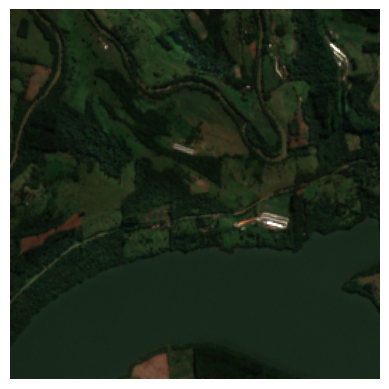

In [7]:
raw_evalscript = """

"""

raw_output = request_helper(raw_evalscript)

print("Max:", raw_output[0].max())
print("Min:", raw_output[0].min())

# Simple scaled visualization for quick check
plt.imshow((raw_output[0] / 3000).clip(0, 1))
plt.axis("off");

<details><summary>See solution</summary>

```js
//VERSION=3
function setup() {
  return {
    input: [{
      bands: ["B04", "B03", "B02"],
      units: "DN"          // ask for digital numbers
    }],
    output: { bands: 3, sampleType: "UINT16" }
  };
}

function evaluatePixel(samples) {
  return [samples.B04, samples.B03, samples.B02];
}
```
</details>


## Computation in evalscripts

We’ve already done some light computations in earlier evalscripts, such as applying scale factors and gain. Another very common calculation in remote sensing is computing an index like the Normalized Difference Vegetation Index (NDVI). Here’s how you can do it in an evalscript.

The first step is to request all the necessary bands. In our case this is B08 (NIR) and B04 (Red). We also need to update our output dictionary, the number of bands has to be one and the sample type FLOAT32, since raw NDVI data is saved as a floating point number. The set up should then look like this:

```js
function setup() {
   return {
       input: ["B04", "B08"],
       output: {
          bands: 1,
          sampleType: "FLOAT32"
       }
   };
}
```

Now in the `evaluatePixel` function we need to calculate the NDVI and return it. For this we have two options. The first one is to write down the formula ourselves:

```js
const ndvi = (samples.B08 - samples.B04) / (samples.B08 + samples.B04);
```

The other option is to use the helper function available called `index()`. This has two advantages, it makes the code a bit simpler and also takes care of the edge case, where the NIR and red values equal 0 in the dividend, which might lead to errors.

```js
const ndvi = index(samples.B08, samples.B04);
```

Let's try it:

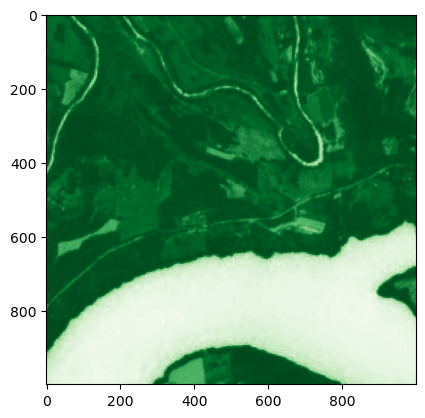

In [8]:
ndvi_raw_evalscript = """
//VERSION=3
function setup() {
   return {
       input: ["B04", "B08"],
       output: {
          bands: 1,
          sampleType: "FLOAT32"
       }
   };
}

function evaluatePixel(samples) {
   const ndvi = index(samples.B08, samples.B04);
   return [ndvi]
}
"""
ndvi_raw = request_helper(ndvi_raw_evalscript)
plt.imshow(ndvi_raw[0], cmap="Greens");

This gives us a nice output of raw NDVI values.

However what we have also seen in the previous section, is that there are often two use cases which require a bit of a different approach in the evalscript. There is the need for requesting analytical data, so getting the raw values. Another very frequent use cases is the need to visualize results on the fly using WMS services or similar. 

## Streaming results with evalscripts

To stream data, Sentinel Hub offers WMS/WMTS services. WMS and WMTS can only return pictures of data, but not the raw data itself. This means, that most often the output type is PNG or JPG with 3 bands corresponding to RGB. The RGB bands have to be in UINT8 (from 0-255).

In our case we return only one band (NDVI) that can not be interpreted as an RGB color as is. It also isn't in UINT8 but FLOAT32 and it doesn't range from 0-255, but from -1 to 1.

Because of this, if we want to visualize our NDVI using WMS services, we need to color encode our raw single band data.

### Visualizing

This can easily be done with the helper functions `ColorRampVisualizer` and `ColorMapVisualizer`. Both use a color map, which maps raw values to RGB colors. The Ramp Visualizer interpolates between those colors, basically creating a continuous gradient between the defined colors. This is used for continuous variables, like our NDVI. The color map visualizer does not do any interpolation and is used mainly for discrete values, like classifications.

So in our case, let's visualize NDVI going from purple at -1, over white at 0, to green at +1:

```js
const colorMap = [
  [-1, 0x8e0152],
  [0, 0xffffff],
  [1, 0x276419],
];

const visualizer = new ColorRampVisualizer(colorMap);
```

We can then use this visualizer to visualize our raw values:

```js
visualizer.process(ndvi)
```

This will return 3 values between 0-1 which can be stretched to UINT8 RGB values using the `AUTO` sampleType. Also notice that in the setup function we have to change the number of output bands from 1 to 3. Let's test it: 

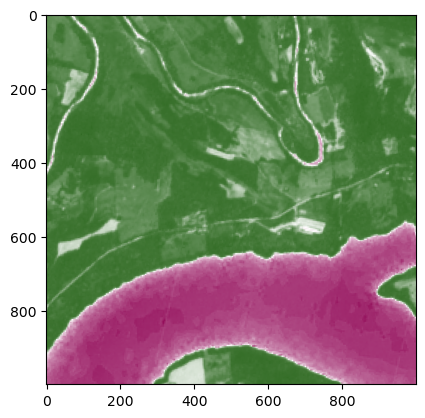

In [9]:
ndvi_visualized_evalscript = """
//VERSION=3
function setup() {
   return {
       input: ["B04", "B08"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

const ramp = [
  [-1, 0x8e0152],
  [0, 0xffffff],
  [1, 0x276419],
];

const visualizer = new ColorRampVisualizer(ramp);

function evaluatePixel(samples) {
   const ndvi = index(samples.B08, samples.B04);
   return visualizer.process(ndvi)
}
"""
ndvi_vis = request_helper(ndvi_visualized_evalscript)
plt.imshow(ndvi_vis[0]);

In the end this looks very similar to what we had before, however this script can be used for streaming data with WMS, while the other can not be used for that.

To summarize: When requesting raw data, use an appropriate `sampleType` and return the data directly. When using an WMS service to stream data you need to visualize the data using one of the available visualizers.

### Exercise

For an exercise you can try this yourself now. Try to adjust the evalscript, so that it returns the Normalized Difference Water Index (NDWI). It is defined as $\frac{green-nir}{green+nir}$. Also adjust the visualization so that it returns everything larger than 0.5 as blue and everything smaller than 0.5 as red. You can use [colorbrewer](https://colorbrewer2.org/#type=diverging&scheme=RdBu&n=11) to get a good color ramp.

<details><summary>See solution</summary>

Raw:

```js
//VERSION=3
function setup() {
   return {
       input: ["B03", "B08"],
       output: {
          bands: 1,
          sampleType: "FLOAT32"
       }
   };
}

function evaluatePixel(samples) {
   const ndwi = index(samples.B03, samples.B08);
   return [ndwi]
}
```

Vis: 

```js
//VERSION=3
function setup() {
   return {
       input: ["B03", "B08"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

const ramp = [
  [-1, 0x67001f],
  [0, 0xffffff],
  [1, 0x053061],
];

const visualizer = new ColorRampVisualizer(ramp);

function evaluatePixel(samples) {
   const ndwi = index(samples.B03, samples.B08);
   return visualizer.process(ndwi)
}
```
</details>

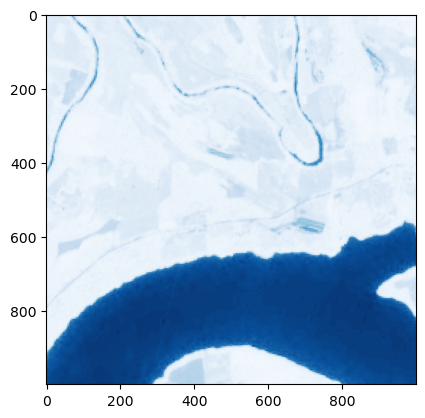

In [10]:
ndwi_raw_evalscript = """

"""
ndwi_raw = request_helper(ndwi_raw_evalscript)
plt.imshow(ndwi_raw[0], cmap="Blues");

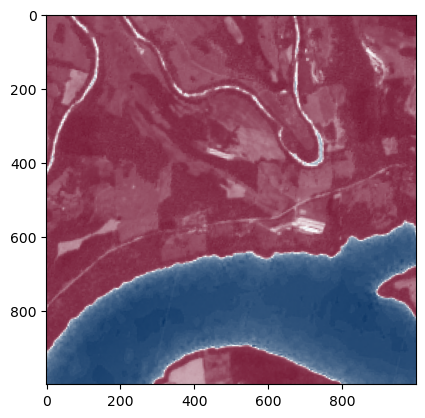

In [11]:
ndwi_visualized_evalscript = """

"""
ndwi_vis = request_helper(ndwi_visualized_evalscript)
plt.imshow(ndwi_vis[0]);

Now, let's change the date and have a look at an image which shows some common inconveniences when working with optical satellite data in general. 

# Dealing with clouds and missing data

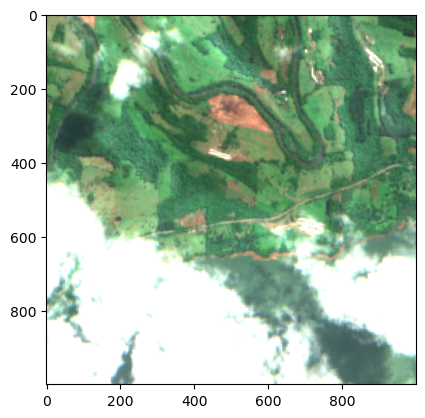

In [12]:
true_color_evalscript = """
//VERSION=3
function setup() {
   return {
       input: ["B04", "B03", "B02"],
       output: {
          bands: 3,
          sampleType: "AUTO"
       }
   };
}

function evaluatePixel(samples) {
   let gain = 3;
   let scale = 2.5*gain;
   return [samples.B04*scale, samples.B03*scale, samples.B02*scale]
}
"""
tc_output = request_helper(true_color_evalscript, date="2024-10-03")
plt.imshow(tc_output[0]);

Here we can see bright areas caused by clouds covering our area of interest. This is a common challenge when working with optical satellite imagery. Some regions may also contain missing data, which appear as empty or transparent areas in the output.

## Visualizing clouds with SCL

This example uses the Sentinel‑2 Scene Classification Layer (SCL) to visually flag cloudy pixels. We treat SCL classes {3, 7, 8, 9, 10} (cloud shadow, unclassified, medium/high‑probability cloud, thin cirrus) as “cloudy/obscuring.” If a pixel falls in these classes, we return a brightened, reddish tint (0.75 + B04, B03, B02) so clouds pop out; otherwise we render true color with a modest brightness boost (3.5 ×). This approach highlights clouds in-place and doesn’t require `dataMask`. If you later want to hide clouds instead of highlighting them, you can return [0,0,0] (or use a transparency channel) for those SCL classes.

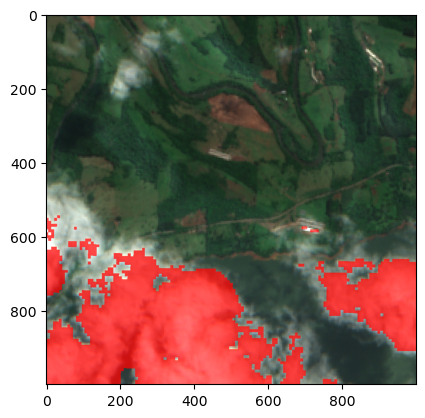

In [13]:
datamask_evalscript = """
//VERSION=3
function setup() {
  return {
    input: ["B02", "B03", "B04", "SCL"],
    output: { bands: 3 }
  }
}

function evaluatePixel(sample) {
  if (sample.SCL == 8 || sample.SCL == 9) {
    return [0.75 + sample.B04, sample.B03, sample.B02]
  }
  return [3.5*sample.B04, 3.5*sample.B03, 3.5*sample.B02];
}
"""
datamask_output = request_helper(datamask_evalscript, date="2024-10-03")
plt.imshow(datamask_output[0], cmap="Greys");

### Hiding clouds with an alpha channel (RGBA)

This version makes cloudy pixels transparent. We use SCL classes {3, 7, 8, 9, 10} as cloudy and set the alpha channel to 0 for those pixels, 1 otherwise. True color is rendered with a small brightness gain. 

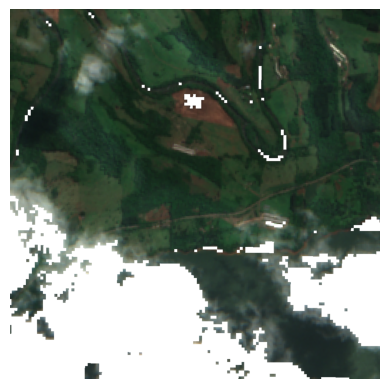

In [14]:
evalscript_cloud_alpha = """
//VERSION=3
function setup() {
  return {
    input: ["B04","B03","B02","SCL"],
    output: { bands: 4, sampleType: "AUTO" } // RGB + Alpha
  };
}

const CLOUDY = [3,7,8,9,10];

function evaluatePixel(samples) {
  var gain = 3.0;
  var rgb = [samples.B04*gain, samples.B03*gain, samples.B02*gain];
  var isCloud = CLOUDY.includes(samples.SCL);
  var alpha = isCloud ? 0 : 1;     // hide clouds
  return rgb.concat(alpha);         // [R,G,B,A]
}
"""
alpha_output = request_helper(evalscript_cloud_alpha, date="2024-10-03")
plt.imshow(alpha_output[0])
plt.axis("off");

# Summary

In this notebook, we explored how to write basic non-temporal evalscripts using the setup and `evaluatePixel` functions. We looked at different `sampleTypes` and saw how the structure of an evalscript depends on the use case.

For streaming visualizations, the script should return RGB(A) images, while for analytics, it can return raw values directly.

We learned how to use the Sentinel-2 Scene Classification Layer (SCL) to detect and visualize clouds, including approaches for highlighting them in place or making them transparent with an alpha channel. You can also check the `dataMask` — a special band provided by Sentinel Hub that indicates which pixels contain valid data. Pixels with a value of 1 are valid (including cloudy pixels), and pixels with a value of 0 represent no data areas, such as regions outside the satellite tile or gaps in coverage. This can be used to filter out invalid pixels in analytics or to set transparency for visualizations. [Learn more about `dataMask`](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript.html#data-mask).

We also reviewed common issues to check when evalscripts don’t produce the expected output and how to use errors to help with debugging.

Do keep in mind that this intro does not cover a few other conecepts, like [evalscripts for statistical API](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Statistical.html), multiple outputs in evalscripts or [returning custom userdata](https://documentation.dataspace.copernicus.eu/APIs/SentinelHub/Evalscript/Functions.html#updateoutputmetadata-function-optional) in the script. See the full documentation which covers everything for these concepts.

Next, we can learn about how multi-temporal evalscripts work on Sentinel Hub.

## Further reading

- [Optimizing evalscripts](https://medium.com/sentinel-hub/custom-scripts-faster-cheaper-better-83f73894658a)
- [Collection of evalscripts](https://custom-scripts.sentinel-hub.com/)
- [Multi-temporal evalscripts](https://medium.com/sentinel-hub/multi-temporal-processing-6a80e5c84188)
- [Color correction with JavaScript](https://medium.com/sentinel-hub/color-correction-with-javascript-d721e12a919)
- [Blog post about Sample Types](https://medium.com/sentinel-hub/sampletype-whats-all-the-fuss-about-d7348b4de647)